# OP2 Demo

Most people are comfortable with the F06.  However, it's:
 - a lot harder to parse
 - much, much, much slower
 - much, much more memory inefficient

The pyNastran OP2 Reader is fast, highly validated, and it supports most result types.

## Validating an OP2

The ```test_op2``` script is created when you run ```python setup.py develop``` or ```python setup.py install``` on pyNastran.  Assuming it's on your path (it'll be in Python27\Scripts or something similar), you can run:

```
>>> test_op2 -f solid_bending.op2
```
The ```-f``` tells us to print out ```solid_bending.test_op2.f06```, which can be compared to your F06 for a small file to build confidence in the reader.  It's also useful when you want an F06 of your model without rerunning Nastran just to see what's in it.

If you have a large model, you can make ```test_op2``` run much, much faster.  The ```-c``` flag disables double-reading of the OP2.  By default, ```test_op2``` uses two different read methods (the old method and new method) to ensure that results are read in properly.  When running the code, this is turned off, but is turned on for ```test_op2```.
```
>>> test_op2 -fc solid_bending.op2
```

## Import the packages

In [23]:
import os
import copy
import numpy as np

import pyNastran
pkg_path = pyNastran.__path__[0]

from pyNastran.utils import print_bad_path
from pyNastran.op2.op2 import OP2
from pyNastran.utils import object_methods, object_attributes

import pandas as pd

### Sets default precision of real numbers for pandas output


In [24]:
pd.set_option('precision', 3)
np.set_printoptions(precision=3, threshold=20)

As with the BDF, we can use the long form and the short form.  However, the long form for the ``OP2`` doesn't really add anything.  So, let's just use the short form.

Besides massive speed improvements in the OP2 relative to v0.7, this version adds ```pandas``` dataframe support.

In [26]:
#op2_filename = r'D:\work\pynastran_0.8.0\models\iSat\ISat_Launch_Sm_Rgd.op2'
#op2_filename = r'D:\work\pynastran_0.8.0\models\iSat\ISat_Launch_Sm_4pt.op2'
op2_filename = os.path.abspath(os.path.join('../../..', 'models', 'solid_bending', 'solid_bending.op2'))
assert os.path.exists(op2_filename), print_bad_path(op2_filename)
print(op2_filename)
!ls /home/git/pyNastran/models/solid_bending/solid_bending.op2

# define the input file with a file path
op2 = OP2()
#op2 = OP2.read_op2(op2_filename, build_dataframe=True, debug=False)
op2 = op2.read_op2(op2_filename, True, True)

/home/git/pyNastran/models/solid_bending/solid_bending.op2
/home/git/pyNastran/models/solid_bending/solid_bending.op2
INFO:      fname=op2.py                    lineNo=107    vectorized=True combine=True
INFO:      fname=op2.py                    lineNo=111    -------- reading op2 with read_mode=1 --------
DEBUG:     fname=op2_scalar.py             lineNo=482    op2_filename = '/home/git/pyNastran/models/solid_bending/solid_bending.op2'
INFO:      fname=op2_scalar.py             lineNo=595      table_name=b'GEOM1'
INFO:      fname=op2_scalar.py             lineNo=595      table_name=b'GEOM2'
INFO:      fname=op2_scalar.py             lineNo=595      table_name=b'GEOM3'
INFO:      fname=op2_scalar.py             lineNo=595      table_name=b'GEOM4'
INFO:      fname=op2_scalar.py             lineNo=595      table_name=b'EPT'
INFO:      fname=op2_scalar.py             lineNo=595      table_name=b'MPTS'
INFO:      fname=op2_scalar.py             lineNo=595      table_name=b'OQG1'
INFO:     

## OP2 Introspection
The ```get_op2_stats()``` function lets you quickly understand what in an op2.

In [28]:
#print(op2.get_op2_stats())

### If that's too long...

In [30]:
#print(op2.get_op2_stats(short=True))

## Acccessing the Eigenvectors object

Eigenvectors are the simplest object.  They use the same class as for displacements, velocity, acceleration, SPC Forces, MPC Forces, Applied Loads, etc.  These are all node-based tables with TX, TY, TZ, RX, RY, RZ.  Results are in the analysis coordinate frame (CD), which is defined by the GRID card.

### Numpy-based Approach
We'll first show off the standard ```numpy``` based results on a transient case.  Static results are the same, except that you'll always use the 0th index for the "time" index.

The tutorial is intetionally just accessing the objects in a very clear, though inefficient way.  The OP2 objects can take full advantage of the numpy operations.

In [36]:
# what modes did we analyze:  1 to 167
print("loadcases = %s" % op2.eigenvectors.keys())

# get subcase 1
eig1 = op2.eigenvectors[1]

modes = eig1.modes
times = eig1._times #  the generic version of modes
print("modes = %s\n" % modes)
print("times = %s\n" % times)

imode2 = 1 # corresponds to mode 2
mode2 = eig1.data[imode2, :, :]

print('first 10 nodes and grid types\nNid Gridtype\n%s' % eig1.node_gridtype[:10, :])
node_ids = eig1.node_gridtype[:, 0]

index_node10 = np.where(node_ids == 10)[0]  # we add the [0] because it's 1d
mode2_node10 = mode2[index_node10]
print("translation mode2_node10 = %s" % eig1.data[imode2, index_node10, :3].ravel())
print("rotations mode2_node10 = %s" % eig1.data[imode2, index_node10, 3:].ravel())

AttributeError: 'NoneType' object has no attribute 'eigenvectors'

### Pandas-based Approach

If you like pandas, you can access all the OP2 objects, which is very useful within the Jupyter Notebook.  Different objects will look differently, but you can change the layout.

If you're trying to learn pandas, there are many tutorials online, such as:
http://pandas.pydata.org/pandas-docs/stable/10min.html

or a very long, but good video:

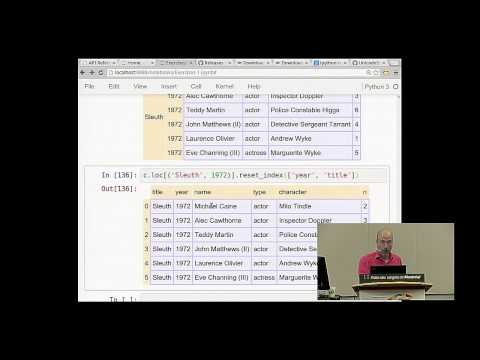

In [34]:
from IPython.display import YouTubeVideo
YouTubeVideo('5JnMutdy6Fw')
#https://www.youtube.com/watch?v=5JnMutdy6Fw

In [37]:
# get subcase 1
eig1 = op2.eigenvectors[1]

print(eig1.data_frame)

AttributeError: 'NoneType' object has no attribute 'eigenvectors'

## Accessing the plate stress/strain
Results are stored on a per element type basis.

The OP2 is the same as an F06, so CQUAD4 elements have centroidal-based results or centroidal-based as well as the results at the 4 corner nodes.

Be careful about what you're accessing.

In [38]:
# element forces/stresses/strains are by element type consistent with the F06, so...
plate_stress = op2.cquad4_stress[1]
print("plate_stress_obj = %s" % type(plate_stress))

# the set of variables in the RealPlateStressArray
print("plate_stress = %s\n" % plate_stress.__dict__.keys())

# list of parameters that define the object (e.g. what is the nonlinear variable name
print("data_code_keys = %s\n" % plate_stress.data_code.keys())

# nonlinear variable name
name = plate_stress.data_code['name']
print("name = %r" % plate_stress.data_code['name'])

print("list-type variables = %s" % plate_stress.data_code['data_names'])

# the special loop parameter
# for modal analysis, it's "modes"
# for transient, it's "times"
# or be lazy and use "_times"
print("modes = %s" % plate_stress.modes) # name + 's'


# extra list-type parameter for modal analysis; see dataNames
#print("mode_cycles =", plate_stress.mode_cycles)

AttributeError: 'NoneType' object has no attribute 'cquad4_stress'

### Similar to the BDF, we can use object_attributes/methods

In [39]:
#print "attributes =", object_attributes(plate_stress)
print("methods = %s\n" % object_methods(plate_stress))
print('methods2= %s\n' % plate_stress.object_methods())
print("headers = %s\n" % plate_stress.get_headers())

NameError: name 'plate_stress' is not defined

### Number of Nodes on a CQUAD4
 - For linear CQUAD4s, there is 1 centroidal stress at two locations 
 - For bilinear quads, there are 5 stresses at two locations (4 nodes + centroidal)
 - node_id=0 indicates a centroidal quantity
 - CTRIA3s are always centroidal

#### What sets this?
    STRESS(real, sort1, BILIN) = ALL   # bilinear cquad
    STRESS(real, sort1, CENT) = ALL    # linear quad

    STRAIN(real, sort1, BILIN) = ALL   # bilinear cquad
    STRAIN(real, sort1, CENT) = ALL    # linear quad

#### How do we know if we're bilinear?
```
print("is_bilinear = %s\n" % plate_stress.is_bilinear())
```

#### What locations are chosen?
 That depends on fiber distance/fiber curvature...
 - fiber_curvature - mean stress (oa) & slope (om)
 
    $$ \sigma_{top} = \sigma_{alt} + \frac{t}{2} \sigma_{mean}$$
    
    $$ \sigma_{btm} = \sigma_{alt} + \frac{t}{2} \sigma_{mean}$$
 
 - fiber_distance - upper and lower surface stress (o_top; o_btm)
 - If you have stress, fiber_distance is always returned regardless of your option.

#### What sets this?
    STRAIN(real, sort1, FIBER) = ALL   # fiber distance/default
    STRAIN(real, sort1, STRCUR) = ALL  # strain curvature


#### How do we know if we're using fiber_distance?
```
print("is_fiber_distance = %s" % plate_stress.is_fiber_distance())
```

## Accessing results

In [40]:
# element forces/stresses/strains are by element type consistent 
# with the F06, so...

def abs_max_min(vals):
    absvals = list(abs(vals))
    maxval = max(absvals)
    i = absvals.index(maxval)
    return vals[i]

#-----------------------------
# again, we have linear quads, so two locations per element
print("element_node[:10, :] =\n%s..." % plate_stress.element_node[:10, :])

# lets get the stress for the first 3 CQUAD4 elements
eids = plate_stress.element_node[:, 0]
ueids = np.unique(eids)
print('ueids = %s' % ueids[:3])

# get the first index of the first 5 elements
ieids = np.searchsorted(eids, ueids[:3])
print('ieids = %s' % ieids)

# the easy way to slice data for linear plates
ieids5 = np.vstack([ieids, ieids + 1]).ravel()
ieids5.sort()

print('verify5:\n%s' % ieids5)

#-----------------------------
itime = 0 # static analysis / mode 1
if plate_stress.is_von_mises():  # True
    ovm = plate_stress.data[itime, :, 7]
    print('we have von mises data; ovm=%s\n' % ovm)
else:
    omax_shear = plate_stress.data[itime, :, 7]
    print('we have max shear data; omax_shear=%s\n' % omax_shear)


print("[layer1, layer2, ...] = %s" % ovm[ieids5])

ieid1000 = np.where(eids == 1000)[0]
print('ieid1000 = %s' % ieid1000)
ovm_mode6_eid1000 = ovm[ieid1000]
print("ovm_mode6_eid1000 = %s -> %s" % (ovm_mode6_eid1000, abs_max_min(ovm_mode6_eid1000)))

NameError: name 'plate_stress' is not defined

In [41]:
# see the difference between "transient"/"modal"/"frequency"-style results
# and "nodal"/"elemental"-style results
# just change imode

imode = 5  # mode 6; could just as easily be dt
iele = 10  # element 10
ilayer = 1

ieid10 = np.where(eids == iele)[0][ilayer]
print('ieid10 = %s' % ieid10)
print(plate_stress.element_node[ieid10, :])


# headers = [u'fiber_distance', u'oxx', u'oyy', u'txy', u'angle', u'omax', u'omin', u'von_mises']
print("ps.modes = %s" % plate_stress.modes[imode])
print("ps.cycles = %s" % plate_stress.cycles[imode])
print("oxx = %s" % plate_stress.data[imode, ieid10, 1])
print("oyy = %s" % plate_stress.data[imode, ieid10, 2])
print("txy = %s" % plate_stress.data[imode, ieid10, 3])
print("omax = %s" % plate_stress.data[imode, ieid10, 5])
print("omin = %s" % plate_stress.data[imode, ieid10, 6])
print("ovm/max_shear = %s" % plate_stress.data[imode, ieid10, 7])

if plate_stress.is_fiber_distance():
    print("fiber_distance = %s" % plate_stress.data[imode, ieid10, 0])
else:
    print("curvature = %s" % plate_stress.data[imode, ieid10, 0])

NameError: name 'eids' is not defined

In [42]:
from pyNastran.bdf.bdf import read_bdf
bdf_filename = os.path.abspath(os.path.join(pkg_path, '..', 'models', 'iSat', 'ISat_Launch_Sm_4pt.dat'))
model = read_bdf(bdf_filename)
mass, cg, I = model.mass_properties()

ImportError: cannot import name 'read_bdf'

In [43]:
import getpass
name = getpass.getuser()
os.chdir(os.path.join(r'C:\Users', name, 'Desktop'))

# write the F06 with Real/Imaginary or Magnitude/Phase
# only matters for complex results
#op2.write_f06('isat.f06', is_mag_phase=False)

!head -n 40 isat.f06
gpw = op2.grid_point_weight
print(gpw.object_attributes())

# The mass results are different as pyNastran's mass assumes point masses.
# The larger your model is and the further from the origin, the more accurate
# the result.
# For some applications (e.g. a weight breakdown), this may be fine.
print('cg =\n%s' % gpw.cg)
print('cg = %s' % cg)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users/emanuele/Desktop'